In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/f21-711-final")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import json
import glob
import os
import matplotlib.pyplot as plt
from utils import comp, show_diff, plot_bar

langs = [
        'nl', 
         'el', 
         'zh',
        'en',
        #  'jp'
        ]


In [ ]:
# os.system('jupyter nbconvert --to html result_analysis.ipynb')


def read_results(folder_name, filename, task = '*'):
    path = folder_name + filename
    data = []
    
    for jsname in glob.glob(path +'/%s.jsonl'%task):
        
        with open(jsname, 'r') as json_file:
            json_list = list(json_file)
            for line in json_list[:]:
                result = json.loads(line)
                
                keys = [ 'prompt', 'sub_label', 'obj_label']
                res = [result[i] for i in keys]

                obj = result['tokenized_obj_label_inflection']
                pred_ind = result['num_mask'] - 1
                pred = result['pred'][pred_ind]
                correct = int(pred == obj)
                res+=[obj, pred, correct]

                data.append(res)
                        
    return pd.DataFrame(data, columns = ['prompt', 'sub_label', 'obj_label', 'tokenized_obj_label_inflection', 'pred', 'correct'])

filenames = [
            
             '/init_all_iter_none/', '/init_all_iter_confidence/'
            ]

df_dict = {}
# langs = []
for filename in filenames:
    
    mb_rates = []
    sb_rates = []
    same_rates = []
    
    for lang in langs:
        print(lang)
        folder_name = 'exp/exp1_' + lang

        s_res = read_results(folder_name, filename)
        m_res = read_results(folder_name + '_m', filename)
        
        mbr, sbr, samer, df = show_diff(s_res, m_res, lang)
        df_dict[lang] = df
        mb_rates.append(mbr)
        sb_rates.append(sbr)
        same_rates.append(samer)




nl
el
zh
en
nl
el
zh
en


In [ ]:
    # Width of a bar 
    width = 0.3       
    N = len(langs)
    ind = np.arange(N)

    # plt.style.use('seaborn-paper')
    
    # Plotting
    # plt.title(filename[1:-1])
    # plt.title('Percentage of correct predictions achieved by MLM only/LSM only/both')
    groups = [mb_rates, sb_rates, same_rates]
    lg = ['MLM only', 'LSM only', 'both']

    for i, gp in enumerate(groups):
        plt.bar(ind + i*width, np.vectorize(lambda x: 100*x)(gp), width, label=lg[i])
    plt.figure(figsize=(200, 100) )
    plt.xticks(ind + width / 2, langs)
    plt.legend(loc='best')
    plt.savefig('err2.png', dpi=100)
    plt.show()

In [ ]:
import pickle
with open('df_dict.pickle', 'wb') as f:
    pickle.dump(df_dict, f)

with open('rates.pickle', 'wb') as f:
    pickle.dump([mb_rates, sb_rates, same_rates], f)

In [ ]:
import pickle
df_dict = pickle.load(open("df_dict.pickle",'rb'))
mb_rates, sb_rates, same_rates = pickle.load(open("rates.pickle",'rb'))


In [ ]:
import matplotlib.pyplot as plt

def analysis(df, lang, filter_func = None):
    dflsm = df[df['better']=='lsm'].dropna()
    dfmlm = df[df['better']=='mlm'].dropna()
    dfsame = df[df['better']=='same'].dropna()

    biased_df = df[df.isnull().any(axis=1)]
    
    plt.figure(figsize=(8, 4), dpi=80).canvas.set_window_title('Distribution of the number of objective tokens for %s'%lang)

    plt.subplot(1, 2, 1).set_title('When LSM performs better')
    lgd = ['lsm only', 'mlm only', 'both']
    # plt.suptitle('When LSM performs better')
    lsmcnt, mlmcnt = np.vectorize(lambda x: len(x))(dflsm['tokenized_obj_label_inflection_lsm']), np.vectorize(lambda x: len(x))(dflsm['tokenized_obj_label_inflection_mlm'])
    lsmcnt2, mlmcnt2 = np.vectorize(lambda x: len(x))(dfmlm['tokenized_obj_label_inflection_lsm']), np.vectorize(lambda x: len(x))(dfmlm['tokenized_obj_label_inflection_mlm'])
    lsmcnt3, mlmcnt3 = np.vectorize(lambda x: len(x))(dfsame['tokenized_obj_label_inflection_lsm']), np.vectorize(lambda x: len(x))(dfsame['tokenized_obj_label_inflection_mlm'])

    plt.hist([1*(lsmcnt<mlmcnt), 1*(lsmcnt2<mlmcnt2),1*(lsmcnt3<mlmcnt3)])
    plt.xticks([0,1,], ['len(lsm)>=mlm', 'lsm<mlm'])
    plt.legend(lgd)
    # plt.show()

    plt.subplot(1, 2, 2).set_title('When MLM performs better')

    plt.hist([lsmcnt, mlmcnt])
    plt.legend(['lsm', 'mlm'])

    plt.show()

# lang = 'nl'  
  
for lang in ['nl', 'en']:
  analysis(df_dict[lang], lang)

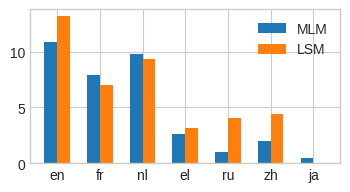

In [ ]:
# exp1 mlm vs lsm for all languages
mult = [10.88, 7.91, 9.77, 2.64, 0.99, 2.01, 0.5]
lsm = [13.17, 6.98, 9.31, 3.12, 4.01, 4.41, 0]
df1 = pd.DataFrame([mult, lsm], columns =['en', 'fr', 'nl', 'el', 'ru', 'zh', 'ja'])
df1 = df1.set_axis(['multilingual BERT','language specific BERT'], axis=0, inplace=False)

# # Plotting
# plt.title('Baseline performance of MLM and LSM on different languages')
groups = [mult, lsm]
lg = ['MLM','LSM']
plt.figure(figsize=(4,2))
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('seaborn-whitegrid')

plot_bar(groups, lg, df1.columns, 'exp1')


In [ ]:
# calculate single/multi token accuracies
def counting(json_list):
    multi_correct = 0
    multi_n = 0
    single_correct = 0
    single_n = 0
    j = 0
    for json_str in json_list:
        result = json.loads(json_str)
        obj = result['tokenized_obj_label_inflection']
        pred_ind = result['num_mask'] - 1
        pred = result['pred'][pred_ind]
        correct = int(pred == obj)
        if len(obj) > 1:
            multi_n += 1
            multi_correct += correct
        else:
            single_n += 1
            single_correct += correct
    return multi_correct, multi_n, single_correct, single_n

def cal_acc(folder_name):
    path = folder_name + '/'
    mc, mn, sc, sn = 0, 0, 0, 0
    for f_name in os.listdir(path):
        if not f_name.endswith('jsonl'):
            continue
        with open(path + f_name, 'r') as json_file:
            json_list = list(json_file)
            a, b, c, d = counting(json_list)
            mc += a
            mn += b
            sc += c
            sn += d
    return mc/mn, sc/sn

In [ ]:
# extract accuracy results from .out files
def extract_result(path):
    data = []
    _, exp_group, name = path.split('/')
    folder_name = path[:-4]
    if 'exp1' in exp_group and '_m' not in exp_group:
        return
    if 'exp1' not in exp_group:
        data.append(exp_group)
    else:
        data.append(exp_group[5:])
    name = name[:-4]
    if name not in settings:
        return 
    components = name.split('_')
    if len(components)>4:
        return None
    data+= [components[i] for i in [1,3]]
    
    for line in open(path, "r", encoding="utf8").readlines()[-1:]:
        res = [line.split()[i] for i in [3, 7]]
        data.append(float(res[0][-6:])*100)
        data.append(float(res[1][:6])*100)
        # multi_acc, single_acc = cal_acc(folder_name)
        # data+=[single_acc*100, multi_acc*100]

    return data

  
def get_acc():

    files = glob.glob('exp/**/*.out')
    res = []
    for file in files:
        res.append(extract_result(file))
        
    df = pd.DataFrame([i for i in res if i is not None], columns = ['lang', 'init','refine', 'acc per fact', 'acc per relation', 
                                                                    # 'single', 'multi'
                                                                  ])
    df = df.drop(['acc per relation'], axis=1)
    lang_vals = df['lang'].unique()


    df = df.groupby(by=[ "init", 'refine', 'lang']).mean().round(2).reset_index()
    df = df.astype('str')
    return df

    dfs = [df[df['lang'] ==i].reset_index(drop = True).drop('lang', axis=1) for i in lang_vals if '_' in i]
    mlmdf = dfs[0]
    for df_ in dfs[1:]:
        mlmdf = mlmdf.merge(df_, on=['init','refine'])
    mlmdf = mlmdf.set_axis(['init','refine'] + [val for val in lang_vals if '_' in val], axis=1, inplace=False)

    dfs = [df[df['lang'] ==i].reset_index(drop = True).drop('lang', axis=1) for i in lang_vals if '_' not in i]
    lsmdf = dfs[0]
    for df_ in dfs[1:]:
        lsmdf = lsmdf.merge(df_, on=['init','refine'])
    lsmdf = lsmdf.set_axis(['init','refine'] + [val for val in lang_vals if '_' not in val], axis=1, inplace=False)

    return mlmdf.max(axis=0)[-4:].astype(float).values, lsmdf.max(axis=0)[-4:].astype(float).values


settings = [
            #  '/init_confidence_iter_none/', 
#              '/init_confidence_iter_confidence/',              
             'init_all_iter_none', 'init_all_iter_confidence'
            ]

acc_df = get_acc()
acc_df

In [ ]:
def merge_df(df):
    df = df.astype('str')
    lang_vals = ['en', 'none', 'zh']
    dfs = [df[df['hlang'] ==i].reset_index(drop = True).drop(['init', 'refine', 'hlang'], axis=1) for i in lang_vals ]
    mlmdf = dfs[0]
    # display(dfs)
    for df_ in dfs[1:]:
        mlmdf = mlmdf.merge(df_, on=['lang'])
    # display(mlmdf)
    return pd.DataFrame(mlmdf.drop(['lang'], axis=1).astype(float).round(2).astype(str))


In [ ]:
def split_lang(x):
  if 'm' in x.split('_'):
    return np.array(x.split('_'))[::-1]
  return np.array(x.split('_'))

acc_df = acc_df[(acc_df['init']=='all') & (acc_df['refine']!='left')] .reset_index(drop=True)
acc= np.vectorize(split_lang, otypes=[np.ndarray], signature='()->(2)')(acc_df['lang'])
comb_df = pd.concat([pd.DataFrame(acc, columns=['hlang', 'lang']), acc_df.drop('lang', axis=1)], axis = 1).sort_values(['init', 'refine', 'hlang', 'lang']).replace({'m':'none'})

In [ ]:
# case analogy results
lrlang = ['el', 'nl', 'jp']

for ref in ['none', 'confidence']:
  # Plotting
  plt.title('with refine='+ ref)
  lg = comb_df['hlang'].unique()
  groups = [comb_df[(comb_df['refine']==ref) & (comb_df['hlang']==l)& (comb_df['lang'].isin(lrlang))]['acc per fact'].astype(float) for l in lg]

  plot_bar(groups, lg, lrlang, 'with refine='+ ref)

In [ ]:
# Width of a bar 
width = 0.3       
N = 4
ind = np.arange(N)
print(plt.style.available)
plt.style.use('seaborn-whitegrid')

# Plotting
# plt.title(filename[1:-1])
plt.title('Performance of MLM on different metrics')
groups = [mlmdf, mlmdata]
print(mlmdf)
lg = ['acc','partial acc']

for i, gp in enumerate(groups):
    plt.bar(ind + i*width, gp, width, label=lg[i])

plt.xticks(ind + width / 2, ["en",	"nl",	"el",	"zh"])
plt.legend(loc='best')
plt.savefig('mlm.png', dpi=200)
plt.show()

plt.title('Performance of LSM on different metrics')
groups = [lsmdf, lsmdata]
# print(mlmdf)
lg = ['acc','partial acc']

for i, gp in enumerate(groups):
    plt.bar(ind + i*width, gp, width, label=lg[i])

plt.xticks(ind + width / 2, ["en",	"nl",	"el",	"zh"])
plt.legend(loc='best')
plt.savefig('lsm.png', dpi=200)
plt.show()


In [ ]:
# generate latex source text
def print_table(df):
    prev_t=1
    now_t=2
    prev_f=1
    now_f=2
    j='&'

    for row in df.values:
        lists = list(row)
        now_t = lists[0]
        now_f = lists[1]    
        if prev_t!= now_t:
            print('\hline')
        else:
            lists[0] = '~'
            if prev_f == now_f:
                lists[1] = '~'
                print('\cline{4-6}')
        prev_t = now_t
        prev_f = now_f
        new_line = j.join(lists)
        print(new_line+'\\\\')
    print('\hline')

print_table(merge_df(comb_df[(comb_df['refine']=='confidence')&(comb_df['lang'].isin(['nl','jp', 'el']))]))

,lang,acc per fact_x,new metric_x,acc per fact_y,new metric_y,acc per fact,new metric
0,el,4.2,5.152,2.76,4.133,3.98,5.803999999999999
1,jp,3.27,5.6,0.86,2.187,1.24,4.658
2,nl,9.75,21.14,9.58,15.561,11.09,18.083


\hline
4.2&5.15&2.76&4.13&3.98&5.8\\
\hline
3.27&5.6&0.86&2.19&1.24&4.66\\
\hline
9.75&21.14&9.58&15.56&11.09&18.08\\
\hline
